In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

### 1º Duration and Convexity

In [2]:
# Carregar os dados mockados
ativos = pd.read_csv('../dataset/ativos.csv')

In [3]:
# Função para calcular o valor presente de fluxos de caixa
def calcular_valor_presente(fluxos, taxa):
    return [cf / ((1 + taxa) ** (t + 1)) for t, cf in enumerate(fluxos)]

In [4]:
# Função para calcular peso dps valores presente
def peso_valor_presente(valor_presente, total):
    return [value/total for value in valor_presente]

In [5]:
# Função para calcular peso dps valores presente (sua soma é o Macaulay duration)
def peso_por_periodo(peso_lista):
    return [periodo*peso for periodo, peso in enumerate(peso_lista)]

In [6]:
# Função para calcular Duration
def calcular_duration(fluxos, taxa):
    vp_total = sum(calcular_valor_presente(fluxos, taxa))
    duration = sum((t + 1) * (cf / ((1 + taxa) ** (t + 1))) for t, cf in enumerate(fluxos)) / vp_total 
    return duration

In [7]:
# Função para calcular Convexity
def calcular_convexity(fluxos, taxa):
    vp_total = sum(calcular_valor_presente(fluxos, taxa))
    convexity = sum(
        (cf * (t + 1) * (t + 2)) / ((1 + taxa) ** (t + 3)) for t, cf in enumerate(fluxos)
    ) / vp_total
    return convexity

In [8]:
# Função para gerar fluxos de caixa
def gerar_fluxos_juros(periodos, valor_inicial, taxa_anual):
    return [round(valor_inicial * ((1 + taxa_anual)**t), 2)for t in range(1, periodos + 1)]

In [9]:
def gerar_fluxos_descont(periodos, valor_mensal, taxa_desconto):
    return [round(valor_mensal / ((1 + taxa_desconto)**t), 2) for t in range(1, periodos + 1)]

In [ ]:
# Iterar sobre os ativos para calcular Duration e Convexity
resultado_ativo = []
for i, ativos_it in ativos.iterrows():
    fluxos = gerar_fluxos_juros(ativos_it['Datas dos Fluxos (T)'], ativos_it['Valor de Mercado (R$)'], ativos_it['Taxa de Juros Atual (%)']) 
    taxa = ativos_it['Taxa de Juros Atual (%)']
    
    duration = calcular_duration(fluxos, taxa)
    convexity = calcular_convexity(fluxos, taxa)
    total = sum(calcular_valor_presente(fluxos, taxa))
    
    resultado_ativo.append({
        'Ativo': ativos_it['Ativo'],
        'Duration': duration,
        'Convexity': convexity,
        'Taxa': taxa,
        'Total': total
    })

6000000.004788046
[1142659.13, 1305669.89, 1491935.62, 1704773.86, 1947975.42, 2225871.9]
[999999.9993803675, 1000000.0007732215, 999999.9997684548, 1000000.0005770407, 1000000.0021574658, 1000000.0021314953]


In [20]:
# Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(resultado_ativo)

In [ ]:
print("Resultados de Duration e Convexity:")

Resultados de Duration e Convexity:
       Ativo  Duration  Convexity      Taxa         Total
0       Vale       3.0   9.700257  0.201358  1.000000e+07
1  Petrobras       2.5   4.759408  0.449518  6.000000e+06
2       Ouro       3.5  14.296620  0.142659  6.000000e+06
3     Dollar       1.5   3.346360  0.093311  1.000000e+06
4    S&P 500       3.0  10.251951  0.168586  5.000000e+06


In [64]:
# Constroi Tabela de cenário determinado por uma variância
def constroi_cenario(duration, convexity, variancia, taxa, total):
    # Construir cenário de variação de juros ao redor da taxa base
    variancia_juros = [
        taxa - variancia * (5 - t) if t < 5 else 
        taxa if t == 5 else 
        taxa + variancia * (t - 5) 
        for t in range(11)
    ]
    
    # Calcular preços baseados em Duration
    preco_titulo_duration = [
        total * (1 - duration * (variancia_juros[t] - taxa))
        for t in range(11)
    ]
    
    # Calcular preços baseados em Duration + Convexity
    preco_titulo_convexity = [
        total * (1 - duration * (variancia_juros[t] - taxa) + 
                 0.5 * convexity * (variancia_juros[t] - taxa)**2)
        for t in range(11)
    ]
    
    # Garantir que o preço no ponto base (taxa inalterada) seja exatamente o total
    preco_titulo_duration[5] = total
    preco_titulo_convexity[5] = total

    # Retornar como DataFrame expandido
    return pd.DataFrame({
        'Variacao Taxa': variancia_juros,
        'Preco Duration': preco_titulo_duration,
        'Preco Convexity': preco_titulo_convexity
    })

In [86]:
def formatar_percentual(x, _):
    return f"{x*100:.0f}%"

In [90]:
def formatar_preco(x, _):
    return f"{x / 1_000_000:.1f}M" 

    Variacao Taxa  Preco Duration  Preco Convexity
0        0.151358    1.150000e+07     1.162125e+07
1        0.161358    1.120000e+07     1.127760e+07
2        0.171358    1.090000e+07     1.094365e+07
3        0.181358    1.060000e+07     1.061940e+07
4        0.191358    1.030000e+07     1.030485e+07
5        0.201358    1.000000e+07     1.000000e+07
6        0.211358    9.700000e+06     9.704850e+06
7        0.221358    9.400000e+06     9.419401e+06
8        0.231358    9.100000e+06     9.143651e+06
9        0.241358    8.800000e+06     8.877602e+06
10       0.251358    8.500000e+06     8.621253e+06
    Variacao Taxa  Preco Duration  Preco Convexity
0        0.399518    6.750000e+06     6.785696e+06
1        0.409518    6.600000e+06     6.622845e+06
2        0.419518    6.450000e+06     6.462850e+06
3        0.429518    6.300000e+06     6.305711e+06
4        0.439518    6.150000e+06     6.151428e+06
5        0.449518    6.000000e+06     6.000000e+06
6        0.459518    5.850000e+

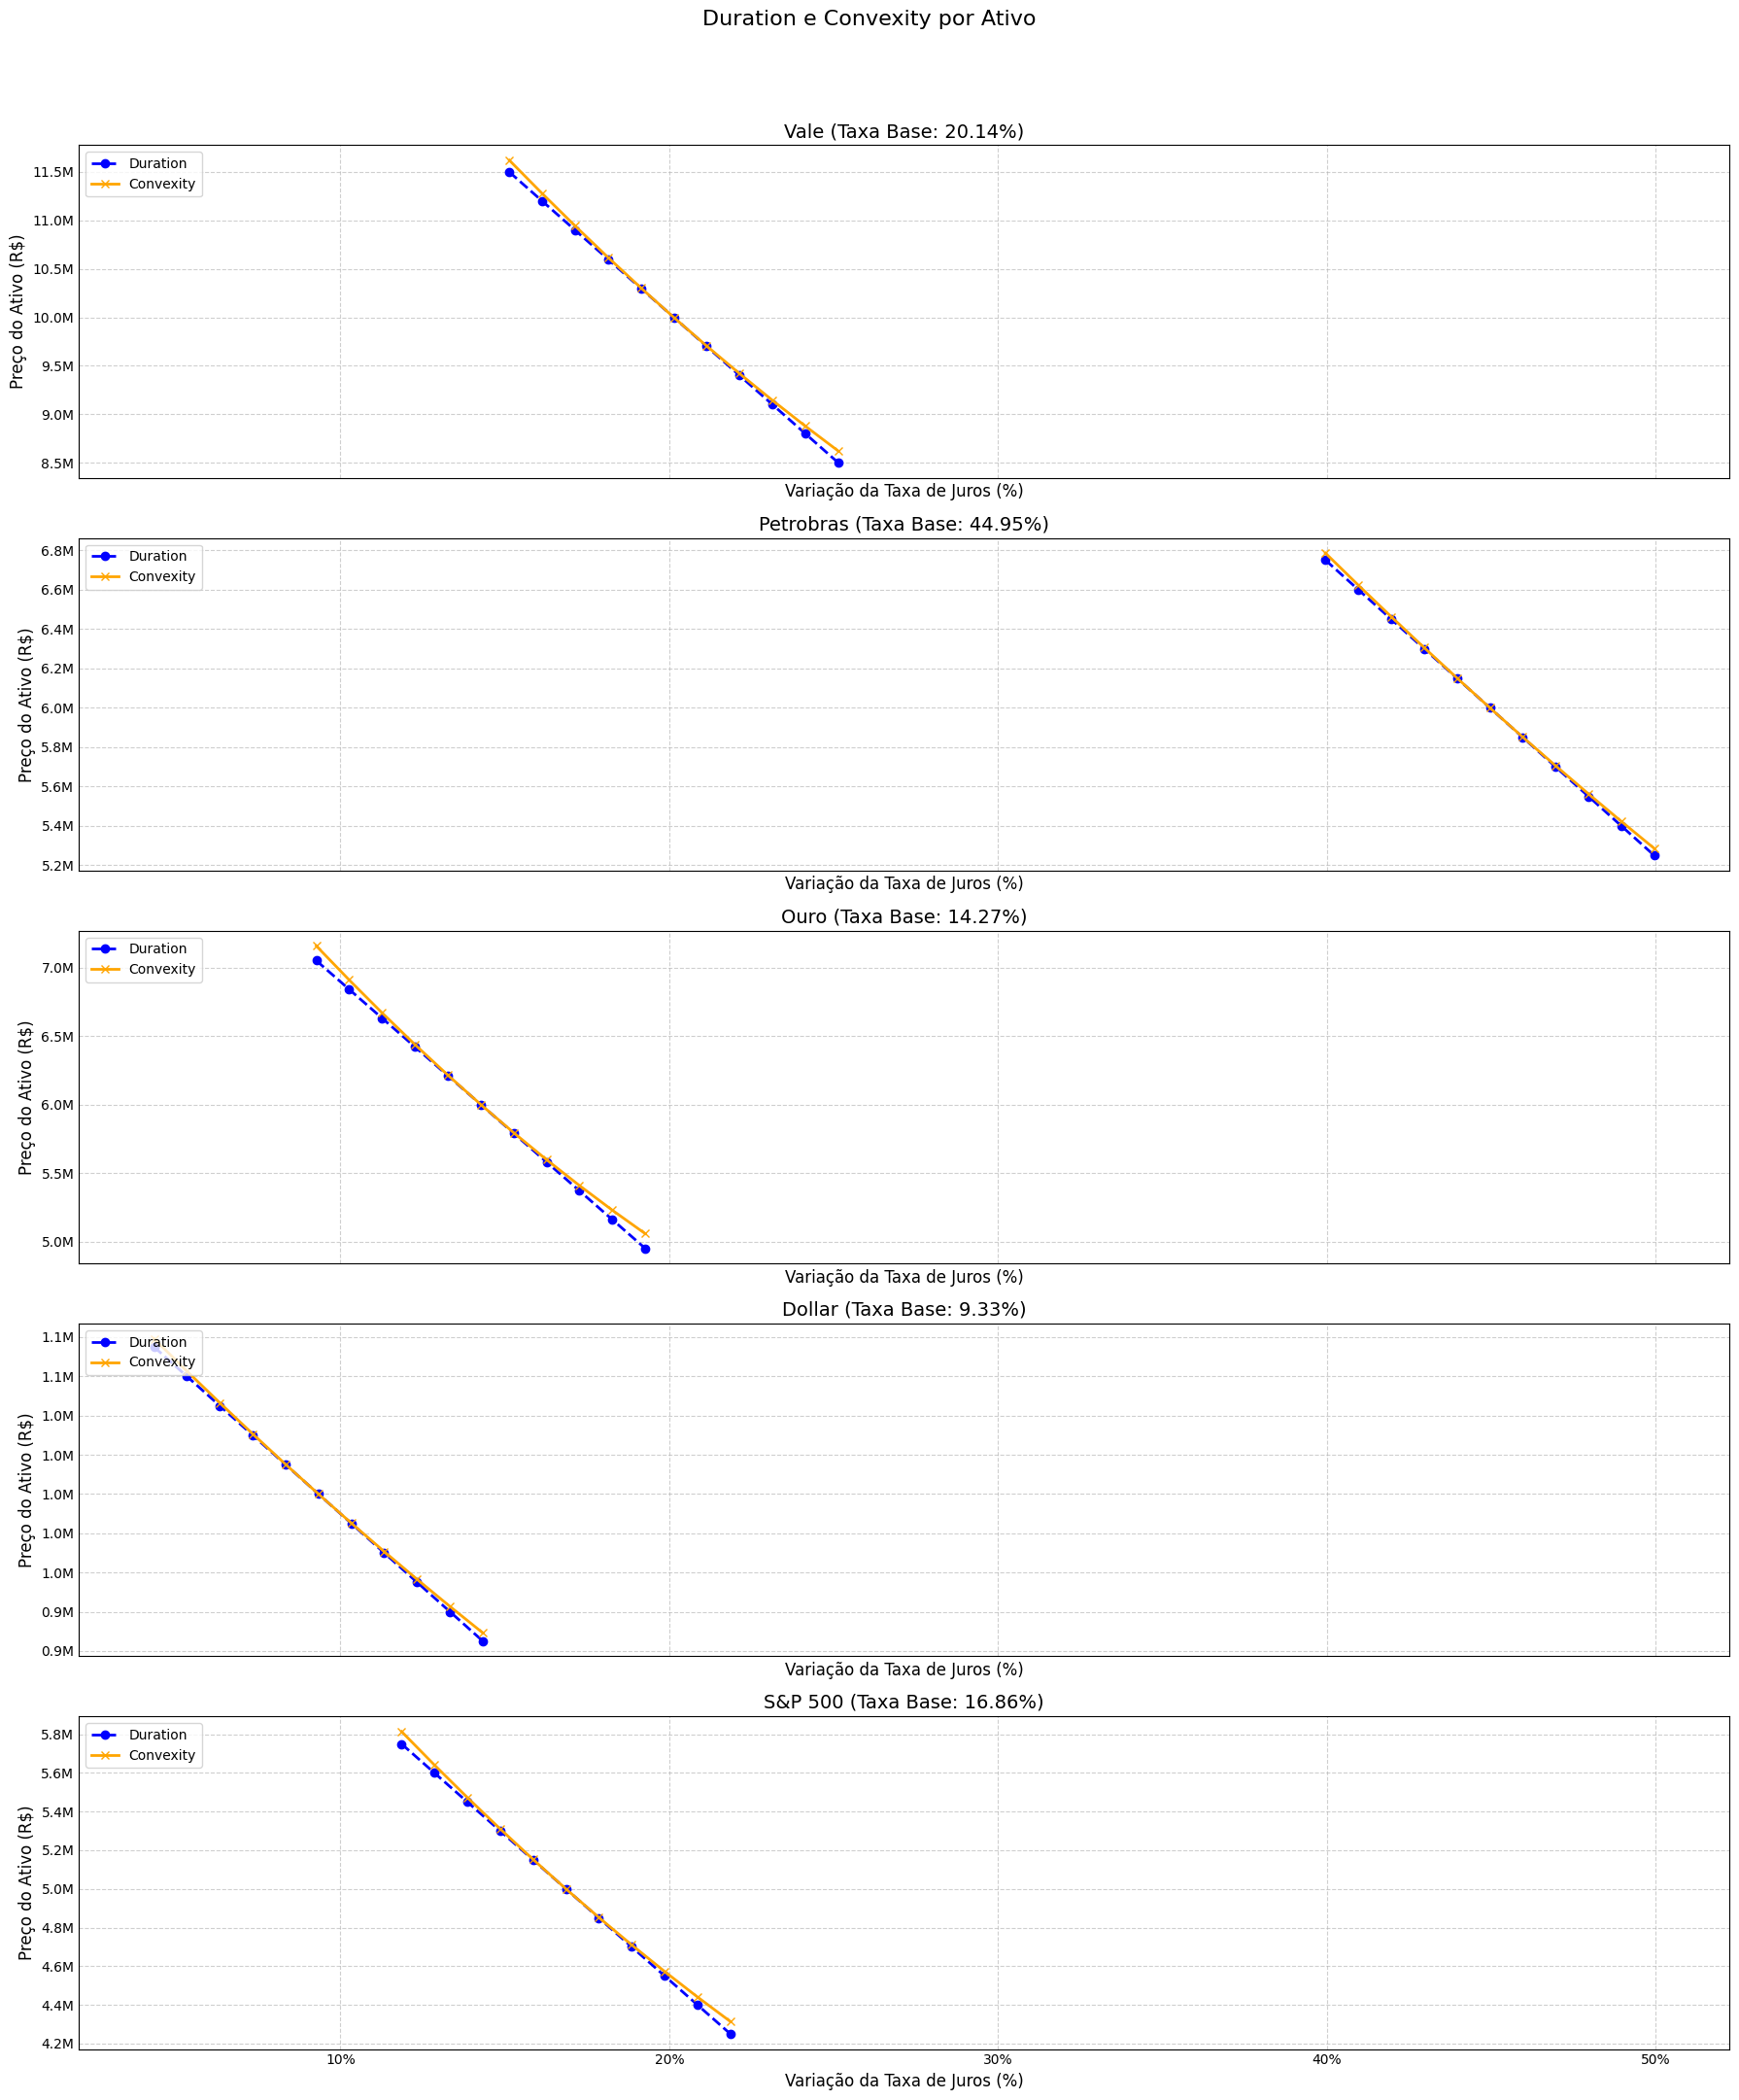

In [ ]:
# Configuração dos gráficos
plt.style.use('_mpl-gallery')
fig, axs = plt.subplots(len(df_resultados), 1, figsize=(18, 22), sharex=True)
fig.suptitle('Duration e Convexity por Ativo', fontsize=16)

for i, (index, row) in enumerate(df_resultados.iterrows()):
    ativo = row['Ativo']
    duration = row['Duration']
    convexity = row['Convexity']
    taxa = row['Taxa']
    total = row['Total']

    df_data = constroi_cenario(duration, convexity, 0.01, taxa, total)
    y = df_data['Preco Duration']
    y2 = df_data['Preco Convexity']
    x = df_data['Variacao Taxa']

    # Gráfico individual
    axs[i].plot(x, y, marker='o', label=f'Duration', color='blue', linestyle='--', linewidth=2)
    axs[i].plot(x, y2, marker='x', label=f'Convexity', color='orange', linestyle='-', linewidth=2)

 # Configurações do subplot
    axs[i].xaxis.set_major_formatter(FuncFormatter(formatar_percentual))
    axs[i].yaxis.set_major_formatter(FuncFormatter(formatar_preco))
    axs[i].set_title(f'{ativo} (Taxa Base: {taxa:.2%})', fontsize=14)
    axs[i].set_xlabel('Variação da Taxa de Juros (%)', fontsize=12)
    axs[i].set_ylabel('Preço do Ativo (R$)', fontsize=12)
    axs[i].legend(loc='upper left', fontsize=10)
    axs[i].grid(True, linestyle='--', alpha=0.6)


# Ajusta para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()